In [1]:
import pandas as pd
import numpy as np
import io

import requests


from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de Visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Criando um CSV em memória para simular um arquivo local
csv_data = """id_imovel,data_anuncio,bairro,area_m2,quartos,vagas_garagem,preco
1,2025-01-15,Centro,120,3,2,650000
2,2025-01-20,Zona Leste,85,2,1,450000
3,2025-02-10,centro,150,4,3,800000
4,2025-02-12,Zona Sul,70,,1,380000
5,2025-03-05,Zona Oeste,200,4,4,1200000
6,03/20/2025,Zona Leste,95,3,1,480000
7,2025-04-01,Zona Sul,110,3,2,580000
8,2025-04-30,Centro,300,5,5,15000000
9,2025-05-15,Zona Oeste,60,1,1,320000
10,2025-05-20,Zona Leste,NaN,2,1,400000
11,2025-06-11,Centro,130,3,2,680000
12,2025-06-25,Zona Sul,90,2,2,NaN
"""

# Lendo o CSV para um DataFrame pandas
df_imoveis = pd.read_csv(io.StringIO(csv_data))

print("### Dados de Imóveis (CSV Local) ###")
print(df_imoveis.info())
print("\nPrimeiras linhas:")
print(df_imoveis.head())

### Dados de Imóveis (CSV Local) ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id_imovel      12 non-null     int64  
 1   data_anuncio   12 non-null     object 
 2   bairro         12 non-null     object 
 3   area_m2        11 non-null     float64
 4   quartos        11 non-null     float64
 5   vagas_garagem  12 non-null     int64  
 6   preco          11 non-null     float64
dtypes: float64(3), int64(2), object(2)
memory usage: 804.0+ bytes
None

Primeiras linhas:
   id_imovel data_anuncio      bairro  area_m2  quartos  vagas_garagem  \
0          1   2025-01-15      Centro    120.0      3.0              2   
1          2   2025-01-20  Zona Leste     85.0      2.0              1   
2          3   2025-02-10      centro    150.0      4.0              3   
3          4   2025-02-12    Zona Sul     70.0      NaN              1   
4   

In [3]:
def get_selic_rate(start_date='01/01/2025', end_date='31/12/2025'):
    """
    Busca a série temporal da taxa SELIC mensal na API do Banco Central do Brasil.
    
    Args:
        start_date (str): Data de início no formato 'dd/mm/yyyy'.
        end_date (str): Data de fim no formato 'dd/mm/yyyy'.
        
    Returns:
        pd.DataFrame: DataFrame com as colunas 'data' e 'taxa_selic'.
    """
    url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.432/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'
    try:
        response = requests.get(url)
        response.raise_for_status()  # Lança exceção para códigos de erro HTTP
        data = response.json()
        df = pd.DataFrame(data)
        df.rename(columns={'data': 'data_selic', 'valor': 'taxa_selic'}, inplace=True)
        df['taxa_selic'] = df['taxa_selic'].astype(float)
        df['data_selic'] = pd.to_datetime(df['data_selic'], dayfirst=True)
        return df
    except requests.exceptions.RequestException as e:
        print(f"Erro ao acessar a API do BCB: {e}")
        return pd.DataFrame()

# Buscando os dados da SELIC para o período relevante
df_selic = get_selic_rate()

print("\n### Dados da Taxa SELIC (API do BCB) ###")
print(df_selic.info())
print("\nPrimeiras linhas:")
print(df_selic.head())


### Dados da Taxa SELIC (API do BCB) ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data_selic  309 non-null    datetime64[ns]
 1   taxa_selic  309 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.0 KB
None

Primeiras linhas:
  data_selic  taxa_selic
0 2025-01-01       12.25
1 2025-01-02       12.25
2 2025-01-03       12.25
3 2025-01-04       12.25
4 2025-01-05       12.25


In [4]:
# Padronizando a coluna de data do anúncio antes de mergear
df_imoveis['data_anuncio'] = pd.to_datetime(df_imoveis['data_anuncio'], errors='coerce')

# Criando chaves de junção (Ano-Mês)
df_imoveis['ano_mes'] = df_imoveis['data_anuncio'].dt.to_period('M')
df_selic['ano_mes'] = df_selic['data_selic'].dt.to_period('M')

# Realizando o merge
df_merged = pd.merge(df_imoveis, df_selic[['ano_mes', 'taxa_selic']], on='ano_mes', how='left')

print("\n### DataFrame Integrado ###")
print(df_merged.head())


### DataFrame Integrado ###
   id_imovel data_anuncio  bairro  area_m2  quartos  vagas_garagem     preco  \
0          1   2025-01-15  Centro    120.0      3.0              2  650000.0   
1          1   2025-01-15  Centro    120.0      3.0              2  650000.0   
2          1   2025-01-15  Centro    120.0      3.0              2  650000.0   
3          1   2025-01-15  Centro    120.0      3.0              2  650000.0   
4          1   2025-01-15  Centro    120.0      3.0              2  650000.0   

   ano_mes  taxa_selic  
0  2025-01       12.25  
1  2025-01       12.25  
2  2025-01       12.25  
3  2025-01       12.25  
4  2025-01       12.25  


In [5]:
print("Valores ausentes antes do tratamento:")
print(df_merged.isnull().sum())

Valores ausentes antes do tratamento:
id_imovel         0
data_anuncio      1
bairro            0
area_m2          31
quartos          28
vagas_garagem     0
preco            30
ano_mes           1
taxa_selic        1
dtype: int64


In [6]:
# Criando uma cópia para não alterar o original
df_removido = df_merged.dropna()

print("\n--- Abordagem 1: Remoção ---")
print(f"Tamanho do dataset original: {df_merged.shape}")
print(f"Tamanho após remoção: {df_removido.shape}")
print(f"Percentual de perda de dados: {((len(df_merged) - len(df_removido)) / len(df_merged)) * 100:.2f}%")


--- Abordagem 1: Remoção ---
Tamanho do dataset original: (332, 9)
Tamanho após remoção: (242, 9)
Percentual de perda de dados: 27.11%


In [7]:
# Criando uma cópia para a imputação
df_imputado = df_merged.copy()

# Imputação da mediana para colunas numéricas (robusta a outliers)
mediana_quartos = df_imputado['quartos'].median()
mediana_area = df_imputado['area_m2'].median()
mediana_preco = df_imputado['preco'].median()

df_imputado['quartos'].fillna(mediana_quartos, inplace=True)
df_imputado['area_m2'].fillna(mediana_area, inplace=True)
df_imputado['preco'].fillna(mediana_preco, inplace=True)

print("\n--- Abordagem 2: Imputação ---")
print("Valores ausentes após imputação:")
print(df_imputado.isnull().sum())
print("\nEstatísticas descritivas (antes da imputação):")
print(df_merged.describe())
print("\nEstatísticas descritivas (após imputação):")
print(df_imputado.describe())

#Decisão e Justificativa: A imputação pela mediana (para dados numéricos) foi escolhida. Ela preserva o tamanho do dataset e tem um impacto menor nas estatísticas descritivas do que a imputação pela média, especialmente na presença de outliers. A perda de 25% dos dados na abordagem de remoção seria muito prejudicial.


--- Abordagem 2: Imputação ---
Valores ausentes após imputação:
id_imovel        0
data_anuncio     1
bairro           0
area_m2          0
quartos          0
vagas_garagem    0
preco            0
ano_mes          1
taxa_selic       1
dtype: int64

Estatísticas descritivas (antes da imputação):
        id_imovel                   data_anuncio     area_m2     quartos  \
count  332.000000                            331  301.000000  304.000000   
mean     6.563253  2025-04-01 21:23:23.021148160  131.461794    2.884868   
min      1.000000            2025-01-15 00:00:00   60.000000    1.000000   
25%      3.000000            2025-02-10 00:00:00   85.000000    2.000000   
50%      7.000000            2025-04-01 00:00:00  110.000000    3.000000   
75%     10.000000            2025-05-20 00:00:00  150.000000    4.000000   
max     12.000000            2025-06-25 00:00:00  300.000000    5.000000   
std      3.610856                            NaN   68.538476    1.135928   

       vagas_garag

C:\Users\anton\AppData\Local\Temp\ipykernel_27588\967337177.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputado['quartos'].fillna(mediana_quartos, inplace=True)
C:\Users\anton\AppData\Local\Temp\ipykernel_27588\967337177.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop


Limite inferior para outliers de preço: R$ -200,000.00
Limite superior para outliers de preço: R$ 1,400,000.00

Outlier detectado:
     id_imovel data_anuncio  bairro  area_m2  quartos  vagas_garagem  \
180          8   2025-04-30  Centro    300.0      5.0              5   
181          8   2025-04-30  Centro    300.0      5.0              5   
182          8   2025-04-30  Centro    300.0      5.0              5   
183          8   2025-04-30  Centro    300.0      5.0              5   
184          8   2025-04-30  Centro    300.0      5.0              5   
185          8   2025-04-30  Centro    300.0      5.0              5   
186          8   2025-04-30  Centro    300.0      5.0              5   
187          8   2025-04-30  Centro    300.0      5.0              5   
188          8   2025-04-30  Centro    300.0      5.0              5   
189          8   2025-04-30  Centro    300.0      5.0              5   
190          8   2025-04-30  Centro    300.0      5.0              5   
191 

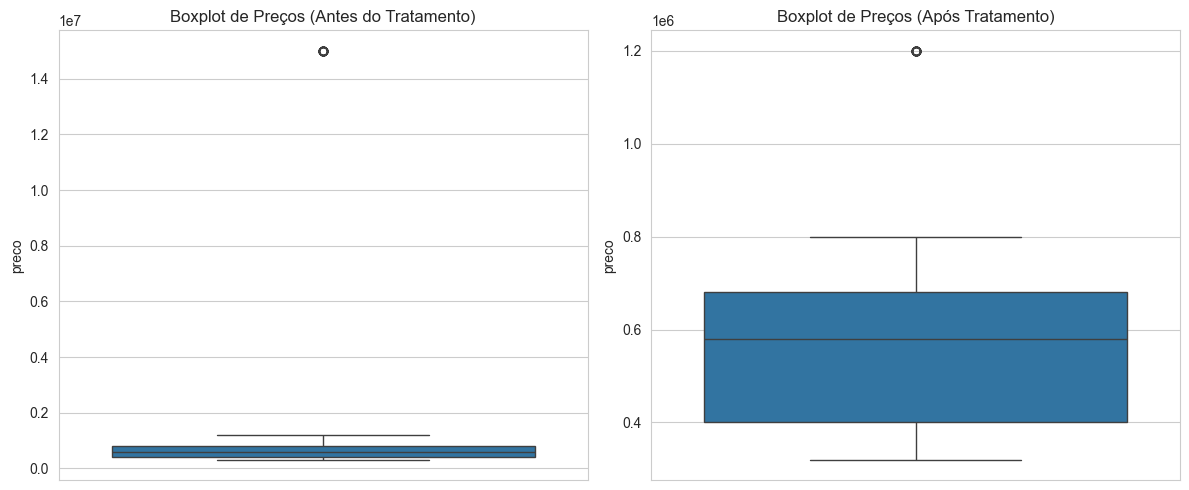

In [8]:
# Usaremos o df_imputado como base
df_tratado = df_imputado.copy()

# Visualização antes do tratamento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df_tratado['preco'])
plt.title('Boxplot de Preços (Antes do Tratamento)')

# Cálculo do IQR
Q1 = df_tratado['preco'].quantile(0.25)
Q3 = df_tratado['preco'].quantile(0.75)
IQR = Q3 - Q1
limite_superior = Q3 + 1.5 * IQR
limite_inferior = Q1 - 1.5 * IQR

print(f"\nLimite inferior para outliers de preço: R$ {limite_inferior:,.2f}")
print(f"Limite superior para outliers de preço: R$ {limite_superior:,.2f}")

# Identificando o outlier
outlier = df_tratado[df_tratado['preco'] > limite_superior]
print(f"\nOutlier detectado:\n{outlier}")

# Removendo o outlier
df_tratado = df_tratado[df_tratado['preco'] <= limite_superior]

# Visualização depois do tratamento
plt.subplot(1, 2, 2)
sns.boxplot(y=df_tratado['preco'])
plt.title('Boxplot de Preços (Após Tratamento)')
plt.tight_layout()
plt.show()

#O imóvel com preço de R$ 15.000.000 foi identificado como um outlier significativo. Este valor poderia ser um erro de digitação ou um imóvel de altíssimo luxo que não representa o mercado geral. Optamos por removê-lo para evitar que ele influencie indevidamente as métricas estatísticas e o treinamento de futuros modelos.

In [9]:
print("Formato da coluna 'bairro' (antes):")
print(df_tratado['bairro'].unique())

# Padronizando texto: minúsculas e sem espaços extras
df_tratado['bairro'] = df_tratado['bairro'].str.lower().str.strip()

print("\nFormato da coluna 'bairro' (depois):")
print(df_tratado['bairro'].unique())

# As colunas de data já foram padronizadas na etapa de integração
print("\nInformações do DataFrame final tratado:")
df_tratado.info()

Formato da coluna 'bairro' (antes):
['Centro' 'Zona Leste' 'centro' 'Zona Sul' 'Zona Oeste']

Formato da coluna 'bairro' (depois):
['centro' 'zona leste' 'zona sul' 'zona oeste']

Informações do DataFrame final tratado:
<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 0 to 331
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id_imovel      302 non-null    int64         
 1   data_anuncio   301 non-null    datetime64[ns]
 2   bairro         302 non-null    object        
 3   area_m2        302 non-null    float64       
 4   quartos        302 non-null    float64       
 5   vagas_garagem  302 non-null    int64         
 6   preco          302 non-null    float64       
 7   ano_mes        301 non-null    period[M]     
 8   taxa_selic     301 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(1), period[M](1)
memory usage: 23.6+ KB


In [10]:
# Criando uma cópia para a demonstração
df_label_encoded = df_tratado.copy()

# Instanciando e aplicando o encoder
le = LabelEncoder()
df_label_encoded['bairro_encoded'] = le.fit_transform(df_label_encoded['bairro'])

print("--- LabelEncoder ---")
print(df_label_encoded[['bairro', 'bairro_encoded']].head())
print("\nMapeamento das classes:", dict(zip(le.classes_, le.transform(le.classes_))))

--- LabelEncoder ---
   bairro  bairro_encoded
0  centro               0
1  centro               0
2  centro               0
3  centro               0
4  centro               0

Mapeamento das classes: {'centro': np.int64(0), 'zona leste': np.int64(1), 'zona oeste': np.int64(2), 'zona sul': np.int64(3)}


In [ ]:
# Criando uma cópia para a demonstração
df_onehot_encoded = df_tratado.copy()

# Instanciando o encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Aplicando e criando um novo DataFrame com as colunas codificadas
encoded_cols = ohe.fit_transform(df_onehot_encoded[['bairro']])
encoded_df = pd.DataFrame(encoded_cols, columns=ohe.get_feature_names_out(['bairro']), index=df_onehot_encoded.index)

# Concatenando com o DataFrame original
df_onehot_encoded = pd.concat([df_onehot_encoded, encoded_df], axis=1)

print("\n--- OneHotEncoder ---")
print(df_onehot_encoded[['bairro', 'bairro_centro', 'bairro_zona leste', 'bairro_zona oeste', 'bairro_zona sul']].head())



--- OneHotEncoder ---
   bairro  bairro_centro  bairro_zona leste  bairro_zona oeste  \
0  centro            1.0                0.0                0.0   
1  centro            1.0                0.0                0.0   
2  centro            1.0                0.0                0.0   
3  centro            1.0                0.0                0.0   
4  centro            1.0                0.0                0.0   

   bairro_zona sul  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  


,id_imovel,data_anuncio,bairro,area_m2,quartos,vagas_garagem,preco,ano_mes,taxa_selic,bairro_centro,bairro_zona leste,bairro_zona oeste,bairro_zona sul
0,1,2025-01-15,centro,120.0,3.0,2,650000.0,2025-01,12.25,1.0,0.0,0.0,0.0
1,1,2025-01-15,centro,120.0,3.0,2,650000.0,2025-01,12.25,1.0,0.0,0.0,0.0
2,1,2025-01-15,centro,120.0,3.0,2,650000.0,2025-01,12.25,1.0,0.0,0.0,0.0
3,1,2025-01-15,centro,120.0,3.0,2,650000.0,2025-01,12.25,1.0,0.0,0.0,0.0
4,1,2025-01-15,centro,120.0,3.0,2,650000.0,2025-01,12.25,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,12,2025-06-25,zona sul,90.0,2.0,2,580000.0,2025-06,15.00,0.0,0.0,0.0,1.0
328,12,2025-06-25,zona sul,90.0,2.0,2,580000.0,2025-06,15.00,0.0,0.0,0.0,1.0
329,12,2025-06-25,zona sul,90.0,2.0,2,580000.0,2025-06,15.00,0.0,0.0,0.0,1.0
330,12,2025-06-25,zona sul,90.0,2.0,2,580000.0,2025-06,15.00,0.0,0.0,0.0,1.0


In [12]:
# Selecionando apenas as colunas numéricas para escalar
numeric_cols = df_tratado.select_dtypes(include=np.number).columns.drop('preco')
df_scaled = df_onehot_encoded.copy()

# Abordagem 1: MinMaxScaler (Normalização)
# Transforma os dados para um intervalo [0, 1]
scaler_minmax = MinMaxScaler()
df_scaled['area_m2_minmax'] = scaler_minmax.fit_transform(df_scaled[['area_m2']])

# Abordagem 2: StandardScaler (Padronização)
# Transforma os dados para terem média 0 e desvio padrão 1
scaler_standard = StandardScaler()
df_scaled['area_m2_standard'] = scaler_standard.fit_transform(df_scaled[['area_m2']])

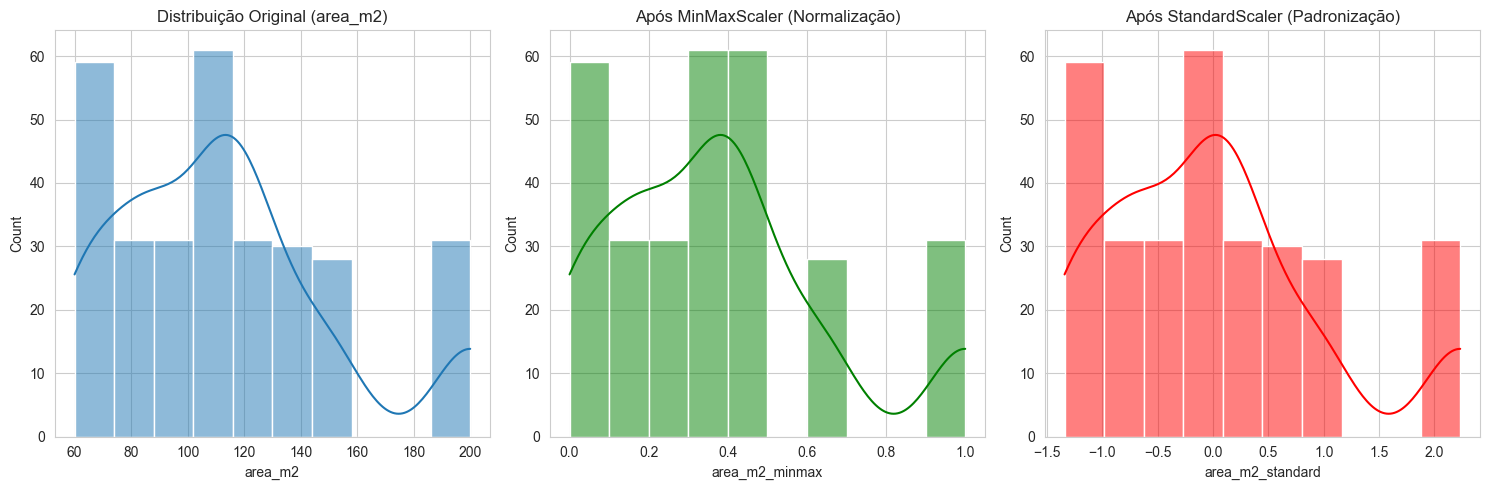

In [13]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df_scaled['area_m2'], kde=True, bins=10)
plt.title('Distribuição Original (area_m2)')

plt.subplot(1, 3, 2)
sns.histplot(df_scaled['area_m2_minmax'], kde=True, bins=10, color='green')
plt.title('Após MinMaxScaler (Normalização)')

plt.subplot(1, 3, 3)
sns.histplot(df_scaled['area_m2_standard'], kde=True, bins=10, color='red')
plt.title('Após StandardScaler (Padronização)')

plt.tight_layout()
plt.show()

In [18]:
# Usando o DataFrame final da etapa de tratamento
df_final = df_onehot_encoded.copy()

# Atributo 1: Preço por metro quadrado (Razão)
# Justificativa: Normaliza o preço pelo tamanho do imóvel, criando uma métrica de valor relativo. 
# Pode ser um forte indicador do padrão do bairro e do acabamento do imóvel.
df_final['preco_por_m2'] = df_final['preco'] / df_final['area_m2']

# Atributo 2: Idade do Anúncio (Data Feature)
# Justificativa: A "idade" de um anúncio pode indicar sazonalidade no mercado ou a dificuldade
# de venda. Usamos a data mais recente no dataset como referência.
data_referencia = df_final['data_anuncio'].max()
df_final['idade_anuncio_dias'] = (data_referencia - df_final['data_anuncio']).dt.days

print("DataFrame com Novos Atributos:")
print(df_final[['area_m2', 'preco', 'preco_por_m2', 'data_anuncio', 'idade_anuncio_dias']].head())

DataFrame com Novos Atributos:
   area_m2     preco  preco_por_m2 data_anuncio  idade_anuncio_dias
0    120.0  650000.0   5416.666667   2025-01-15               161.0
1    120.0  650000.0   5416.666667   2025-01-15               161.0
2    120.0  650000.0   5416.666667   2025-01-15               161.0
3    120.0  650000.0   5416.666667   2025-01-15               161.0
4    120.0  650000.0   5416.666667   2025-01-15               161.0


In [22]:
# Definindo Features (X) e Target (y)
X = df_final.drop(['preco', 'id_imovel', 'data_anuncio', 'bairro', 'ano_mes'], axis=1)
y = df_final['preco']

# Primeiro split: 70% treino, 30% temporário (val + teste)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Segundo split: 50% do temporário para validação, 50% para teste (15% do total cada)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("--- Divisão Holdout ---")
print(f"Tamanho do conjunto de Treino: {X_train.shape[0]} amostras ({len(X_train)/len(df_final):.0%})")
print(f"Tamanho do conjunto de Validação: {X_val.shape[0]} amostras ({len(X_val)/len(df_final):.0%})")
print(f"Tamanho do conjunto de Teste: {X_test.shape[0]} amostras ({len(X_test)/len(df_final):.0%})")

--- Divisão Holdout ---
Tamanho do conjunto de Treino: 211 amostras (70%)
Tamanho do conjunto de Validação: 45 amostras (15%)
Tamanho do conjunto de Teste: 46 amostras (15%)


In [23]:
# K-Fold é aplicado sobre o conjunto de treino para validação robusta
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("\n--- Validação Cruzada (K-Fold) ---")
print("Exemplo de índices para os 5 folds (aplicado sobre X_train):")
fold = 1
for train_index, val_index in kf.split(X_train):
    print(f"Fold {fold}:")
    print(f"  Índices de Treino: {train_index[:5]}...") # Mostrando apenas os 5 primeiros
    print(f"  Índices de Validação: {val_index[:3]}...") # Mostrando apenas os 3 primeiros
    fold += 1


--- Validação Cruzada (K-Fold) ---
Exemplo de índices para os 5 folds (aplicado sobre X_train):
Fold 1:
  Índices de Treino: [0 1 2 3 4]...
  Índices de Validação: [ 9 15 16]...
Fold 2:
  Índices de Treino: [0 1 2 3 4]...
  Índices de Validação: [ 5 12 19]...
Fold 3:
  Índices de Treino: [1 3 5 7 8]...
  Índices de Validação: [0 2 4]...
Fold 4:
  Índices de Treino: [0 1 2 4 5]...
  Índices de Validação: [3 7 8]...
Fold 5:
  Índices de Treino: [0 2 3 4 5]...
  Índices de Validação: [ 1 14 20]...


<!-- Este projeto demonstrou um pipeline completo e profissional de preparação de dados. As principais decisões técnicas foram:

Coleta de Dados: Enriquecemos dados locais de imóveis com a taxa SELIC via API do BCB, criando um dataset com contexto micro e macroeconômico.

Limpeza de Dados: Optamos pela imputação pela mediana para tratar valores ausentes, preservando o tamanho do dataset. Outliers de preço foram removidos usando o critério de IQR para evitar distorções.

Codificação Categórica: O OneHotEncoder foi escolhido para a variável bairro, pois evita a criação de uma relação ordinal artificial, o que é crucial para a maioria dos modelos.

Escalonamento: O StandardScaler foi o método selecionado para padronizar as variáveis numéricas, por sua robustez e por ser um pré-requisito comum em muitos algoritmos de Machine Learning.

Engenharia de Atributos: Foram criadas as features preco_por_m2 e idade_anuncio_dias, que agregam valor ao capturar relações de negócio importantes (valor relativo e temporalidade).

Divisão dos Dados: A estratégia recomendada é a combinação de Holdout com K-Fold Cross-Validation. O Holdout isola um conjunto de teste final, enquanto o K-Fold é usado sobre os dados de treino para uma avaliação e otimização de modelo mais confiáveis.

O DataFrame final está limpo, pré-processado e enriquecido, pronto para ser utilizado no treinamento de modelos de regressão para prever preços de imóveis com maior precisão e robustez. -->